# Ozon Masters DS contest 2021
https://www.kaggle.com/c/ozon-masters-ds-contest-2021/overview

Москаленко Андрей

Решение задания я начал с изучения данных. Наивно полагая, что в них нет ликов в начале делал упор на изучение скилов пользователей и их выбор персонажей.  

Первые шаги:  
* Приведение категориально закодированных героев в единый бинарный вектор-признак на 100 персонажей. Этот бейзлайн получил паблик скор в **0.64187**. Так же попробовал применить tf-idf для кодирования самых популярных комбинаций (я брал топ-700), но ощутимого прироста не получил, а время обучения в 3 часа на GPU из-за количества фичей получил...
* Добавление винрейтов. Сначала я предпосчитал винрейты по всем героям и добавлял по 8 фичей вероятностей победы каждому игроку, а так же средний винрейт. Была надежда, что какие-то герои более сильные, однако значимых отклонений не было - герои сбалансированы (это можно было понять и из уловия, но я ему не верил т.к. там сказано что порядок игроков не влияет, при том что 2ой выигрывает в 2 раза чаще :) ).
* Винрейты пользователей и пользователей-героев. Сразу было понятно, что это сильный лик, т.к. если у игрока винрейт 100% и одна игра, то победа в текущем наблюдении гарантирована. Чтоб избежать таких недоразумений я считал винрейт только для игроков с >10 играми. Аналогично винрейты считал для пары пользователь-герой. К сожалению, даже с ограничением на число игр лик был сильным и качество просаживалось на валидации хуже, чем бейзлайн модель с корзиной персонажей.
* Плейрейты. Раз винрейты приводят к лику, появилась идея добавить плейрейты т.е. доля игр для игрока с данным персонажем. Мотивировано это тем, что по условию игроки прокачивают персонажей и по данным часто играют с одними и теми же. Т.е. вероятнее более прокаченный персонаж более весом. Эта фича подняла паблик скор до **0.63678**.
* Взаимодействие персонажей. На похожих соревнованиях (https://www.kaggle.com/c/mlcourse-dota2-win-prediction/discussion, https://www.kaggle.com/c/dota-2-win-probability-prediction/discussion) вдохновлялся идеями про синергию персонажей. Была использована фича, отражающая "силу" команды одного игрока над другим путем сложения условных вероятностей P(победа с героем N | у противоположного игрока есть персонаж M). Эта фича продвинула мой паблик скор до **0.63250**


Понимание, что что-то идет не так: 
* В какой-то момент в лидер борде появился человек с скором, существенно лучшим, чем у остальных участников. Стало понятно, что в данных есть какая-то утечка таргета, которую я принялся искать.
* Добавление фичей на глобальный рейтинг. Проанализировав историю по пользователям, стало понятно, что рейтинг растет при победе и падает при поражении. Т.е. если в текущей игре рейтинг на историческом минимуме, вероятнее всего, человек выйграет. В этот момент я ещё не знал, что порядок игр мы можем восстановить, поэтому сделал фичи на глобальный рейтинг пользователя. Туда вошли функции вида минимум, максимум, средняя, дисперсии и куча hand-crafted комбинаций из них. Это дало существенный прирост до **0.60329**.
* Перцентили. Зачем использовать экстремальные статистики минимума-максимума, когда можно оценить положение текущего рейтинга в истории более точно. Добавление фичей на перцентили рейтинга улучшило скор до **0.58015**.
* Локальный рейтинг. До этого момента мне казалось, что фича X21 отражает продолжительность игры а не её время. Но увидев несколько одинаковых значений у одного пользователя стало ясно, что это какой-то таймстемп, например, день. Т.е. легко восстановить порядок игр, если знать, что человек играет раз в день. А зная порядок по динамике рейтинга легко понять таргеты. Но видимо, чтоб нам было не очень скучно, этот таймстемп сделан довольно грубым, т.е. у пользователя мб много игр в один день и там уже установить порядок не получится. Поэтому я сделал фичи похожие на предыдущий пункт, но учитывающие историю на прошлый, текущий и следующие дни, если они есть, а так же множество их комбинаций. Это повысило скор до **0.39719**.

Выбор модели:
* Не было, т.к. сразу было ясно, что нужна деревянная модель для улавливания зависимостей между персонажами, остановился на catboost.
* Тьюнингом не занимался, только эмпирически увеличил глубину до 10, кол-во раундов до 20к и поднял lr т.к. оверфита не возникало даже на последних итерациях бустинга.


Как воспроизвести ноутбук:
* Предпосчитать все фичи из последней части ноутбука (либо взять готовые npy-файлы)
* Фичи, не использованные в финальном предсказании закомиченны
* Для получения предсказания запустить ноутбук Test.ipynb (модель с чекпоинтом кэтбуста приложена)
* Топ-100 фичей финальной модели:

![title](100.png)

In [1]:
import pandas as pd
import tqdm
import numpy as np
import seaborn as sns
import scipy

In [2]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [3]:
train_data = pd.read_csv('./train.csv')

In [5]:
test_data = pd.read_csv('./test.csv')

In [6]:
data = train_data.append(test_data)

In [57]:
rates = np.load('./rates.npy', allow_pickle=True).item()
heroes_stats_total = np.load('./heroes_stats_total.npy', allow_pickle=True).item()

In [131]:
test_data = pd.read_csv('./test.csv')
TEST = test_data.drop(['id'], axis=1)

for i in range(101):
    TEST['1HERO_' + str(i)] = 0

for i in range(101):
    TEST['2HERO_' + str(i)] = 0   
    
for idx, row in tqdm.notebook.tqdm(TEST.iterrows()):
    for x in ['X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12']:
        TEST.at[idx, '1HERO_' + str(row[x])] += 1

    for x in ['X13', 'X14', 'X15', 'X16', 'X17','X18', 'X19', 'X20']:
        TEST.at[idx, '2HERO_' + str(row[x])] += 1

#TEST.to_csv('G:/TEST.csv')

In [4]:
X, y = train_data.drop(['id', 'target'], axis=1), train_data['target']

In [4]:
y = train_data['target']

In [5]:
del train_data

In [6]:
for i in range(101):
    X['1HERO_' + str(i)] = 0

for i in range(101):
    X['2HERO_' + str(i)] = 0    
    
for idx, row in tqdm.notebook.tqdm(X.iterrows()):
    for x in ['X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12']:
        X.at[idx, '1HERO_' + str(row[x])] += 1

    for x in ['X13', 'X14', 'X15', 'X16', 'X17','X18', 'X19', 'X20']:
        X.at[idx, '2HERO_' + str(row[x])] += 1

In [6]:
#X = pd.read_csv('G:/X.csv')
#X = pd.read_csv('G:/X_hero_winrate_fixed.csv')
#X = pd.read_csv('G:/X_with_prev_next_days.csv')
#X = pd.read_csv('G:/X_hero_user_playrate.csv')

# Локальные рейтинги по дням

In [4]:
ITER = X[['X1', 'X2', 'X3', 'X4', 'X21']]

In [5]:
X['MEAN_PREV_LEFT'] = 0.0
X['MIN_PREV_LEFT'] = 0.0
X['MAX_PREV_LEFT'] = 0.0
X['STD_PREV_LEFT'] = 0.0
X['PERCENTILE_PREV_LEFT'] = 0.0
X['MEAN_PREV_RIGHT'] = 0.0
X['MIN_PREV_RIGHT'] = 0.0
X['MAX_PREV_RIGHT'] = 0.0
X['STD_PREV_RIGHT'] = 0.0
X['PERCENTILE_PREV_RIGHT'] = 0.0

In [6]:
X['MEAN_CURR_LEFT'] = 0.0
X['MIN_CURR_LEFT'] = 0.0
X['MAX_CURR_LEFT'] = 0.0
X['STD_CURR_LEFT'] = 0.0
X['PERCENTILE_CURR_LEFT'] = 0.0
X['MEAN_CURR_RIGHT'] = 0.0
X['MIN_CURR_RIGHT'] = 0.0
X['MAX_CURR_RIGHT'] = 0.0
X['STD_CURR_RIGHT'] = 0.0
X['PERCENTILE_CURR_RIGHT'] = 0.0

In [7]:
X['MEAN_NEXT_LEFT'] = 0.0
X['MIN_NEXT_LEFT'] = 0.0
X['MAX_NEXT_LEFT'] = 0.0
X['STD_NEXT_LEFT'] = 0.0
X['PERCENTILE_NEXT_LEFT'] = 0.0
X['MEAN_NEXT_RIGHT'] = 0.0
X['MIN_NEXT_RIGHT'] = 0.0
X['MAX_NEXT_RIGHT'] = 0.0
X['STD_NEXT_RIGHT'] = 0.0
X['PERCENTILE_NEXT_RIGHT'] = 0.0

In [8]:
day_by_day = np.load('./day_by_day_ratings.npy', allow_pickle=True).item()

In [9]:
from bisect import *
def index(a, x):
    'Locate the leftmost value exactly equal to x'
    i = bisect_left(a, x)
    if i != len(a) and a[i] == x:
        return i
    raise ValueError

def find_lt(a, x):
    'Find rightmost value less than x'
    i = bisect_left(a, x)
    if i:
        return a[i-1]
    raise ValueError

def find_le(a, x):
    'Find rightmost value less than or equal to x'
    i = bisect_right(a, x)
    if i:
        return a[i-1]
    raise ValueError

def find_gt(a, x):
    'Find leftmost value greater than x'
    i = bisect_right(a, x)
    if i != len(a):
        return a[i]
    raise ValueError

def find_ge(a, x):
    'Find leftmost item greater than or equal to x'
    i = bisect_left(a, x)
    if i != len(a):
        return a[i]
    raise ValueError

In [11]:
for idx, row in tqdm.tqdm(ITER.iterrows()):
    left = day_by_day[row['X1']]
    right = day_by_day[row['X3']]
    
    left_keys = list(left.keys())
    right_keys = list(right.keys())
    
    curr_day_left = left[int(row['X21'])]
    curr_day_right = right[int(row['X21'])]
    
    
    try:
        next_day_left = left[find_gt(left_keys, int(row['X21']))]
    except:
        next_day_left = curr_day_left
        
    try:
        next_day_right = left[find_gt(right_keys, int(row['X21']))]
    except:
        next_day_right = curr_day_right
        
    try:
        prev_day_left = left[find_lt(left_keys, int(row['X21']))]
    except:
        prev_day_left = curr_day_left
        
    try:
        prev_day_right = left[find_lt(right_keys, int(row['X21']))]
    except:
        prev_day_right = curr_day_right    
    
    X.at[idx, 'MEAN_CURR_LEFT'] = np.mean(curr_day_left)
    X.at[idx, 'MIN_CURR_LEFT'] = np.min(curr_day_left)
    X.at[idx, 'MAX_CURR_LEFT'] = np.max(curr_day_left)
    X.at[idx, 'STD_CURR_LEFT'] = np.std(curr_day_left)
    X.at[idx, 'PERCENTILE_CURR_LEFT'] = scipy.stats.percentileofscore(curr_day_left, row['X2'])
    
    X.at[idx, 'MEAN_CURR_RIGHT'] = np.mean(curr_day_right)
    X.at[idx, 'MIN_CURR_RIGHT'] = np.min(curr_day_right)
    X.at[idx, 'MAX_CURR_RIGHT'] = np.max(curr_day_right)
    X.at[idx, 'STD_CURR_RIGHT'] = np.std(curr_day_right)
    X.at[idx, 'PERCENTILE_CURR_RIGHT'] = scipy.stats.percentileofscore(curr_day_right, row['X4'])
  

    X.at[idx, 'MEAN_PREV_LEFT'] = np.mean(prev_day_left)
    X.at[idx, 'MIN_PREV_LEFT'] = np.min(prev_day_left)
    X.at[idx, 'MAX_PREV_LEFT'] = np.max(prev_day_left)
    X.at[idx, 'STD_PREV_LEFT'] = np.std(prev_day_left)
    X.at[idx, 'PERCENTILE_PREV_LEFT'] = scipy.stats.percentileofscore(prev_day_left, row['X2'])
    
    X.at[idx, 'MEAN_PREV_RIGHT'] = np.mean(prev_day_right)
    X.at[idx, 'MIN_PREV_RIGHT'] = np.min(prev_day_right)
    X.at[idx, 'MAX_PREV_RIGHT'] = np.max(prev_day_right)
    X.at[idx, 'STD_PREV_RIGHT'] = np.std(prev_day_right)
    X.at[idx, 'PERCENTILE_PREV_RIGHT'] = scipy.stats.percentileofscore(prev_day_right, row['X4'])
    
    
    X.at[idx, 'MEAN_NEXT_LEFT'] = np.mean(next_day_left)
    X.at[idx, 'MIN_NEXT_LEFT'] = np.min(next_day_left)
    X.at[idx, 'MAX_NEXT_LEFT'] = np.max(next_day_left)
    X.at[idx, 'STD_NEXT_LEFT'] = np.std(next_day_left)
    X.at[idx, 'PERCENTILE_NEXT_LEFT'] = scipy.stats.percentileofscore(next_day_left, row['X2'])
    
    X.at[idx, 'MEAN_NEXT_RIGHT'] = np.mean(next_day_right)
    X.at[idx, 'MIN_NEXT_RIGHT'] = np.min(next_day_right)
    X.at[idx, 'MAX_NEXT_RIGHT'] = np.max(next_day_right)
    X.at[idx, 'STD_NEXT_RIGHT'] = np.std(next_day_right)
    X.at[idx, 'PERCENTILE_NEXT_RIGHT'] = scipy.stats.percentileofscore(next_day_right, row['X4'])

3633005it [59:21, 1020.09it/s]


In [12]:
#X.to_csv('G:\X_with_prev_next_days.csv')

In [6]:
import dask.dataframe as dd

In [7]:
types = {}

In [8]:
for key in dict(dd.read_csv('G:/X_rating_and_playrate_and_prev_next_day.csv').dtypes).keys():
    types[key] = np.float32

In [9]:
X = pd.read_csv('G:/X_rating_and_playrate_and_prev_next_day.csv', dtype=types)

In [10]:
X['X0'] = X['X0'].astype(str)

In [11]:
X['MAX_MIN_PREV_LEFT'] = (X['MAX_PREV_LEFT'] - X['MIN_PREV_LEFT']) / X['MEAN_PREV_LEFT']
X['MAX_TO_MEAN_PREV_LEFT'] = X['MAX_PREV_LEFT'] / X['MEAN_PREV_LEFT']
X['MIN_TO_MEAN_PREV_LEFT'] = X['MIN_PREV_LEFT'] / X['MEAN_PREV_LEFT']
X['STD_TO_MEAN_PREV_LEFT'] = X['STD_PREV_LEFT'] / X['MEAN_PREV_LEFT']

X['MAX_MIN_PREV_RIGHT'] = (X['MAX_PREV_RIGHT'] - X['MIN_PREV_RIGHT']) / X['MEAN_PREV_RIGHT']
X['MAX_TO_MEAN_PREV_RIGHT'] = X['MAX_PREV_RIGHT'] / X['MEAN_PREV_RIGHT']
X['MIN_TO_MEAN_PREV_RIGHT'] = X['MIN_PREV_RIGHT'] / X['MEAN_PREV_RIGHT']
X['STD_TO_MEAN_PREV_RIGHT'] = X['STD_PREV_RIGHT'] / X['MEAN_PREV_RIGHT']



X['MAX_MIN_CURR_LEFT'] = (X['MAX_CURR_LEFT'] - X['MIN_CURR_LEFT']) / X['MEAN_CURR_LEFT']
X['MAX_TO_MEAN_CURR_LEFT'] = X['MAX_CURR_LEFT'] / X['MEAN_CURR_LEFT']
X['MIN_TO_MEAN_CURR_LEFT'] = X['MIN_CURR_LEFT'] / X['MEAN_CURR_LEFT']
X['STD_TO_MEAN_CURR_LEFT'] = X['STD_CURR_LEFT'] / X['MEAN_CURR_LEFT']

X['MAX_MIN_CURR_RIGHT'] = (X['MAX_CURR_RIGHT'] - X['MIN_CURR_RIGHT']) / X['MEAN_CURR_RIGHT']
X['MAX_TO_MEAN_CURR_RIGHT'] = X['MAX_CURR_RIGHT'] / X['MEAN_CURR_RIGHT']
X['MIN_TO_MEAN_CURR_RIGHT'] = X['MIN_CURR_RIGHT'] / X['MEAN_CURR_RIGHT']
X['STD_TO_MEAN_CURR_RIGHT'] = X['STD_CURR_RIGHT'] / X['MEAN_CURR_RIGHT']



X['MAX_MIN_NEXT_LEFT'] = (X['MAX_NEXT_LEFT'] - X['MIN_NEXT_LEFT']) / X['MEAN_NEXT_LEFT']
X['MAX_TO_MEAN_NEXT_LEFT'] = X['MAX_NEXT_LEFT'] / X['MEAN_NEXT_LEFT']
X['MIN_TO_MEAN_NEXT_LEFT'] = X['MIN_NEXT_LEFT'] / X['MEAN_NEXT_LEFT']
X['STD_TO_MEAN_NEXT_LEFT'] = X['STD_NEXT_LEFT'] / X['MEAN_NEXT_LEFT']

X['MAX_MIN_NEXT_RIGHT'] = (X['MAX_NEXT_RIGHT'] - X['MIN_NEXT_RIGHT']) / X['MEAN_NEXT_RIGHT']
X['MAX_TO_MEAN_NEXT_RIGHT'] = X['MAX_NEXT_RIGHT'] / X['MEAN_NEXT_RIGHT']
X['MIN_TO_MEAN_NEXT_RIGHT'] = X['MIN_NEXT_RIGHT'] / X['MEAN_NEXT_RIGHT']
X['STD_TO_MEAN_NEXT_RIGHT'] = X['STD_NEXT_RIGHT'] / X['MEAN_NEXT_RIGHT']

In [12]:
X['PREV_MAX_DIV_MIN_LEFT'] = X['MAX_PREV_LEFT'] / X['MIN_PREV_LEFT']
X['PREV_MAX_DIV_MIN_RIGHT'] = X['MAX_PREV_RIGHT'] / X['MIN_PREV_RIGHT']

X['PREV_MAX_DIV_MEAN_LEFT'] = X['MAX_PREV_LEFT'] / X['MEAN_PREV_LEFT']
X['PREV_MAX_DIV_MEAN_RIGHT'] = X['MAX_PREV_RIGHT'] / X['MEAN_PREV_RIGHT']

X['PREV_MIN_DIV_MEAN_LEFT'] = X['MIN_PREV_LEFT'] / X['MEAN_PREV_LEFT']
X['PREV_MIN_DIV_MEAN_RIGHT'] = X['MIN_PREV_RIGHT'] / X['MEAN_PREV_RIGHT']

X['PREV_MAX_MINUS_MIN_LEFT'] = X['MAX_PREV_LEFT'] - X['MIN_PREV_LEFT']
X['PREV_MAX_MINUS_MIN_RIGHT'] = X['MAX_PREV_RIGHT'] - X['MIN_PREV_RIGHT']

X['PREV_MAX_MINUS_MEAN_LEFT'] = X['MAX_PREV_LEFT'] - X['MEAN_PREV_LEFT']
X['PREV_MAX_MINUS_MEAN_RIGHT'] = X['MAX_PREV_RIGHT'] - X['MEAN_PREV_RIGHT']

X['PREV_MEAN_MINUS_MIN_LEFT'] = X['MEAN_PREV_LEFT'] - X['MIN_PREV_LEFT']
X['PREV_MEAN_MINUS_MIN_RIGHT'] = X['MEAN_PREV_RIGHT'] - X['MIN_PREV_RIGHT']

X['PREV_CURR_DIV_MEAN_LEFT'] = X['X2'] / X['MEAN_PREV_LEFT']
X['PREV_CURR_DIV_MEAN_RIGHT'] = X['X4'] / X['MEAN_PREV_RIGHT']

X['PREV_MEAN_MINUS_CURR_LEFT'] = X['MEAN_PREV_LEFT'] - X['X2']
X['PREV_MEAN_MINUS_CURR_RIGHT'] = X['MEAN_PREV_RIGHT'] - X['X4']

X['PREV_MAX_MINUS_CURR_LEFT'] = (X['MAX_PREV_LEFT'] - X['X2']) / X['MEAN_PREV_LEFT']
X['PREV_MAX_MINUS_CURR_RIGHT'] = (X['MAX_PREV_RIGHT'] - X['X4']) / X['MEAN_PREV_RIGHT']

X['PREV_MIN_MINUS_CURR_LEFT'] = (X['MIN_PREV_LEFT'] - X['X2']) / X['MEAN_PREV_LEFT']
X['PREV_MIN_MINUS_CURR_RIGHT'] = (X['MIN_PREV_RIGHT'] - X['X4']) / X['MEAN_PREV_RIGHT']

X['PREV_STD_DIV_MEAN_LEFT'] = X['STD_PREV_LEFT'] / X['MEAN_PREV_LEFT']
X['PREV_STD_DIV_MEAN_RIGHT'] = X['STD_PREV_RIGHT'] / X['MEAN_PREV_RIGHT']


X['PREV_STD_DIV_CURR_LEFT'] = X['STD_PREV_LEFT'] / X['X2']
X['PREV_STD_DIV_CURR_RIGHT'] = X['STD_PREV_RIGHT'] / X['X4']


X['PREV_MAX_MINUS_MIN_NORMALIZED_LEFT'] = (X['MAX_PREV_LEFT'] - X['MIN_PREV_LEFT']) / X['MEAN_PREV_LEFT']
X['PREV_MAX_MINUS_MIN_NORMALIZED_RIGHT'] = (X['MAX_PREV_RIGHT'] - X['MIN_PREV_RIGHT']) / X['MEAN_PREV_RIGHT']

X['PREV_MAX_MINUS_CURR_NN_LEFT'] = X['MAX_PREV_LEFT'] - X['X2']
X['PREV_MAX_MINUS_CURR_NN_RIGHT'] = X['MAX_PREV_RIGHT'] - X['X4']

X['PREV_MIN_MINUS_CURR_NN_LEFT'] = X['MIN_PREV_LEFT'] - X['X2']
X['PREV_MIN_MINUS_CURR_NN_RIGHT'] = X['MIN_PREV_RIGHT'] - X['X4']

X['PREV_MAX_DIV_CURR_LEFT'] = X['MAX_PREV_LEFT'] / X['X2']
X['PREV_MAX_DIV_CURR_RIGHT'] = X['MAX_PREV_RIGHT'] / X['X4']

X['PREV_MIN_DIV_CURR_LEFT'] = X['MIN_PREV_LEFT'] / X['X2']
X['PREV_MIN_DIV_CURR_RIGHT'] = X['MIN_PREV_RIGHT'] / X['X4']

In [13]:
X['CURR_MAX_DIV_MIN_LEFT'] = X['MAX_CURR_LEFT'] / X['MIN_CURR_LEFT']
X['CURR_MAX_DIV_MIN_RIGHT'] = X['MAX_CURR_RIGHT'] / X['MIN_CURR_RIGHT']

X['CURR_MAX_DIV_MEAN_LEFT'] = X['MAX_CURR_LEFT'] / X['MEAN_CURR_LEFT']
X['CURR_MAX_DIV_MEAN_RIGHT'] = X['MAX_CURR_RIGHT'] / X['MEAN_CURR_RIGHT']

X['CURR_MIN_DIV_MEAN_LEFT'] = X['MIN_CURR_LEFT'] / X['MEAN_CURR_LEFT']
X['CURR_MIN_DIV_MEAN_RIGHT'] = X['MIN_CURR_RIGHT'] / X['MEAN_CURR_RIGHT']

X['CURR_MAX_MINUS_MIN_LEFT'] = X['MAX_CURR_LEFT'] - X['MIN_CURR_LEFT']
X['CURR_MAX_MINUS_MIN_RIGHT'] = X['MAX_CURR_RIGHT'] - X['MIN_CURR_RIGHT']

X['CURR_MAX_MINUS_MEAN_LEFT'] = X['MAX_CURR_LEFT'] - X['MEAN_CURR_LEFT']
X['CURR_MAX_MINUS_MEAN_RIGHT'] = X['MAX_CURR_RIGHT'] - X['MEAN_CURR_RIGHT']

X['CURR_MEAN_MINUS_MIN_LEFT'] = X['MEAN_CURR_LEFT'] - X['MIN_CURR_LEFT']
X['CURR_MEAN_MINUS_MIN_RIGHT'] = X['MEAN_CURR_RIGHT'] - X['MIN_CURR_RIGHT']

X['CURR_CURR_DIV_MEAN_LEFT'] = X['X2'] / X['MEAN_CURR_LEFT']
X['CURR_CURR_DIV_MEAN_RIGHT'] = X['X4'] / X['MEAN_CURR_RIGHT']

X['CURR_MEAN_MINUS_CURR_LEFT'] = X['MEAN_CURR_LEFT'] - X['X2']
X['CURR_MEAN_MINUS_CURR_RIGHT'] = X['MEAN_CURR_RIGHT'] - X['X4']

X['CURR_MAX_MINUS_CURR_LEFT'] = (X['MAX_CURR_LEFT'] - X['X2']) / X['MEAN_CURR_LEFT']
X['CURR_MAX_MINUS_CURR_RIGHT'] = (X['MAX_CURR_RIGHT'] - X['X4']) / X['MEAN_CURR_RIGHT']

X['CURR_MIN_MINUS_CURR_LEFT'] = (X['MIN_CURR_LEFT'] - X['X2']) / X['MEAN_CURR_LEFT']
X['CURR_MIN_MINUS_CURR_RIGHT'] = (X['MIN_CURR_RIGHT'] - X['X4']) / X['MEAN_CURR_RIGHT']

X['CURR_STD_DIV_MEAN_LEFT'] = X['STD_CURR_LEFT'] / X['MEAN_CURR_LEFT']
X['CURR_STD_DIV_MEAN_RIGHT'] = X['STD_CURR_RIGHT'] / X['MEAN_CURR_RIGHT']


X['CURR_STD_DIV_CURR_LEFT'] = X['STD_CURR_LEFT'] / X['X2']
X['CURR_STD_DIV_CURR_RIGHT'] = X['STD_CURR_RIGHT'] / X['X4']


X['CURR_MAX_MINUS_MIN_NORMALIZED_LEFT'] = (X['MAX_CURR_LEFT'] - X['MIN_CURR_LEFT']) / X['MEAN_CURR_LEFT']
X['CURR_MAX_MINUS_MIN_NORMALIZED_RIGHT'] = (X['MAX_CURR_RIGHT'] - X['MIN_CURR_RIGHT']) / X['MEAN_CURR_RIGHT']

X['CURR_MAX_MINUS_CURR_NN_LEFT'] = X['MAX_CURR_LEFT'] - X['X2']
X['CURR_MAX_MINUS_CURR_NN_RIGHT'] = X['MAX_CURR_RIGHT'] - X['X4']

X['CURR_MIN_MINUS_CURR_NN_LEFT'] = X['MIN_CURR_LEFT'] - X['X2']
X['CURR_MIN_MINUS_CURR_NN_RIGHT'] = X['MIN_CURR_RIGHT'] - X['X4']

X['CURR_MAX_DIV_CURR_LEFT'] = X['MAX_CURR_LEFT'] / X['X2']
X['CURR_MAX_DIV_CURR_RIGHT'] = X['MAX_CURR_RIGHT'] / X['X4']

X['CURR_MIN_DIV_CURR_LEFT'] = X['MIN_CURR_LEFT'] / X['X2']
X['CURR_MIN_DIV_CURR_RIGHT'] = X['MIN_CURR_RIGHT'] / X['X4']

In [14]:
X['NEXT_MAX_DIV_MIN_LEFT'] = X['MAX_NEXT_LEFT'] / X['MIN_NEXT_LEFT']
X['NEXT_MAX_DIV_MIN_RIGHT'] = X['MAX_NEXT_RIGHT'] / X['MIN_NEXT_RIGHT']

X['NEXT_MAX_DIV_MEAN_LEFT'] = X['MAX_NEXT_LEFT'] / X['MEAN_NEXT_LEFT']
X['NEXT_MAX_DIV_MEAN_RIGHT'] = X['MAX_NEXT_RIGHT'] / X['MEAN_NEXT_RIGHT']

X['NEXT_MIN_DIV_MEAN_LEFT'] = X['MIN_NEXT_LEFT'] / X['MEAN_NEXT_LEFT']
X['NEXT_MIN_DIV_MEAN_RIGHT'] = X['MIN_NEXT_RIGHT'] / X['MEAN_NEXT_RIGHT']

X['NEXT_MAX_MINUS_MIN_LEFT'] = X['MAX_NEXT_LEFT'] - X['MIN_NEXT_LEFT']
X['NEXT_MAX_MINUS_MIN_RIGHT'] = X['MAX_NEXT_RIGHT'] - X['MIN_NEXT_RIGHT']

X['NEXT_MAX_MINUS_MEAN_LEFT'] = X['MAX_NEXT_LEFT'] - X['MEAN_NEXT_LEFT']
X['NEXT_MAX_MINUS_MEAN_RIGHT'] = X['MAX_NEXT_RIGHT'] - X['MEAN_NEXT_RIGHT']

X['NEXT_MEAN_MINUS_MIN_LEFT'] = X['MEAN_NEXT_LEFT'] - X['MIN_NEXT_LEFT']
X['NEXT_MEAN_MINUS_MIN_RIGHT'] = X['MEAN_NEXT_RIGHT'] - X['MIN_NEXT_RIGHT']

X['NEXT_CURR_DIV_MEAN_LEFT'] = X['X2'] / X['MEAN_NEXT_LEFT']
X['NEXT_CURR_DIV_MEAN_RIGHT'] = X['X4'] / X['MEAN_NEXT_RIGHT']

X['NEXT_MEAN_MINUS_CURR_LEFT'] = X['MEAN_NEXT_LEFT'] - X['X2']
X['NEXT_MEAN_MINUS_CURR_RIGHT'] = X['MEAN_NEXT_RIGHT'] - X['X4']

X['NEXT_MAX_MINUS_CURR_LEFT'] = (X['MAX_NEXT_LEFT'] - X['X2']) / X['MEAN_NEXT_LEFT']
X['NEXT_MAX_MINUS_CURR_RIGHT'] = (X['MAX_NEXT_RIGHT'] - X['X4']) / X['MEAN_CURR_RIGHT']

X['NEXT_MIN_MINUS_CURR_LEFT'] = (X['MIN_NEXT_LEFT'] - X['X2']) / X['MEAN_NEXT_LEFT']
X['NEXT_MIN_MINUS_CURR_RIGHT'] = (X['MIN_NEXT_RIGHT'] - X['X4']) / X['MEAN_NEXT_RIGHT']

X['NEXT_STD_DIV_MEAN_LEFT'] = X['STD_NEXT_LEFT'] / X['MEAN_NEXT_LEFT']
X['NEXT_STD_DIV_MEAN_RIGHT'] = X['STD_NEXT_RIGHT'] / X['MEAN_NEXT_RIGHT']


X['NEXT_STD_DIV_CURR_LEFT'] = X['STD_NEXT_LEFT'] / X['X2']
X['NEXT_STD_DIV_CURR_RIGHT'] = X['STD_NEXT_RIGHT'] / X['X4']


X['NEXT_MAX_MINUS_MIN_NORMALIZED_LEFT'] = (X['MAX_NEXT_LEFT'] - X['MIN_NEXT_LEFT']) / X['MEAN_NEXT_LEFT']
X['NEXT_MAX_MINUS_MIN_NORMALIZED_RIGHT'] = (X['MAX_NEXT_RIGHT'] - X['MIN_NEXT_RIGHT']) / X['MEAN_NEXT_RIGHT']

X['NEXT_MAX_MINUS_CURR_NN_LEFT'] = X['MAX_NEXT_LEFT'] - X['X2']
X['NEXT_MAX_MINUS_CURR_NN_RIGHT'] = X['MAX_NEXT_RIGHT'] - X['X4']

X['NEXT_MIN_MINUS_CURR_NN_LEFT'] = X['MIN_NEXT_LEFT'] - X['X2']
X['NEXT_MIN_MINUS_CURR_NN_RIGHT'] = X['MIN_NEXT_RIGHT'] - X['X4']

X['NEXT_MAX_DIV_CURR_LEFT'] = X['MAX_NEXT_LEFT'] / X['X2']
X['NEXT_MAX_DIV_CURR_RIGHT'] = X['MAX_NEXT_RIGHT'] / X['X4']

X['NEXT_MIN_DIV_CURR_LEFT'] = X['MIN_NEXT_LEFT'] / X['X2']
X['NEXT_MIN_DIV_CURR_RIGHT'] = X['MIN_NEXT_RIGHT'] / X['X4']

In [15]:
X['NEXT_PREV_MAX_DIV_MIN_LEFT'] = X['MAX_NEXT_LEFT'] / X['MIN_PREV_LEFT']
X['NEXT_PREV_MAX_DIV_MIN_RIGHT'] = X['MAX_NEXT_RIGHT'] / X['MIN_PREV_RIGHT']

X['NEXT_PREV_MAX_DIV_MEAN_LEFT'] = X['MAX_NEXT_LEFT'] / X['MEAN_PREV_LEFT']
X['NEXT_PREV_MAX_DIV_MEAN_RIGHT'] = X['MAX_NEXT_RIGHT'] / X['MEAN_PREV_RIGHT']

X['NEXT_PREV_MIN_DIV_MEAN_LEFT'] = X['MIN_NEXT_LEFT'] / X['MEAN_PREV_LEFT']
X['NEXT_PREV_MIN_DIV_MEAN_RIGHT'] = X['MIN_NEXT_RIGHT'] / X['MEAN_PREV_RIGHT']

X['NEXT_PREV_MAX_MINUS_MIN_LEFT'] = X['MAX_NEXT_LEFT'] - X['MIN_PREV_LEFT']
X['NEXT_PREV_MAX_MINUS_MIN_RIGHT'] = X['MAX_NEXT_RIGHT'] - X['MIN_PREV_RIGHT']

X['NEXT_PREV_MAX_MINUS_MEAN_LEFT'] = X['MAX_NEXT_LEFT'] - X['MEAN_PREV_LEFT']
X['NEXT_PREV_MAX_MINUS_MEAN_RIGHT'] = X['MAX_NEXT_RIGHT'] - X['MEAN_PREV_RIGHT']

X['NEXT_PREV_MEAN_MINUS_MIN_LEFT'] = X['MEAN_NEXT_LEFT'] - X['MIN_PREV_LEFT']
X['NEXT_PREV_MEAN_MINUS_MIN_RIGHT'] = X['MEAN_NEXT_RIGHT'] - X['MIN_PREV_RIGHT']

X['NEXT_PREV_STD_DIV_MEAN_LEFT'] = X['STD_NEXT_LEFT'] / X['MEAN_PREV_LEFT']
X['NEXT_PREV_STD_DIV_MEAN_RIGHT'] = X['STD_NEXT_RIGHT'] / X['MEAN_PREV_RIGHT']

X['NEXT_PREV_MAX_MINUS_MIN_NORMALIZED_LEFT'] = (X['MAX_NEXT_LEFT'] - X['MIN_PREV_LEFT']) / X['MEAN_NEXT_LEFT']
X['NEXT_PREV_MAX_MINUS_MIN_NORMALIZED_RIGHT'] = (X['MAX_NEXT_RIGHT'] - X['MIN_PREV_RIGHT']) / X['MEAN_NEXT_RIGHT']



In [16]:
X['PREV_MAX_DIV_MIN_DIFF'] = X['PREV_MAX_DIV_MIN_LEFT'] - X['PREV_MAX_DIV_MIN_RIGHT']
X['PREV_MAX_DIV_MEAN_DIFF'] = X['PREV_MAX_DIV_MEAN_LEFT'] - X['PREV_MAX_DIV_MEAN_RIGHT']
X['PREV_MIN_DIV_MEAN_DIFF'] = X['PREV_MIN_DIV_MEAN_LEFT'] - X['PREV_MIN_DIV_MEAN_RIGHT']
X['PREV_MAX_MINUS_MIN_DIFF'] = X['PREV_MAX_MINUS_MIN_LEFT'] - X['PREV_MAX_MINUS_MIN_RIGHT']
X['PREV_MAX_MINUS_MEAN_DIFF'] = X['PREV_MAX_MINUS_MEAN_LEFT'] - X['PREV_MAX_MINUS_MEAN_RIGHT']
X['PREV_MEAN_MINUS_MIN_DIFF'] = X['PREV_MEAN_MINUS_MIN_LEFT'] - X['PREV_MEAN_MINUS_MIN_RIGHT']
X['PREV_CURR_DIV_MEAN_DIFF'] = X['PREV_CURR_DIV_MEAN_LEFT'] - X['PREV_CURR_DIV_MEAN_RIGHT']
X['PREV_MEAN_MINUS_CURR_DIFF'] = X['PREV_MEAN_MINUS_CURR_LEFT'] - X['PREV_MEAN_MINUS_CURR_RIGHT']
X['PREV_MAX_MINUS_CURR_DIFF'] = X['PREV_MAX_MINUS_CURR_LEFT'] - X['PREV_MAX_MINUS_CURR_RIGHT']
X['PREV_MIN_MINUS_CURR_DIFF'] = X['PREV_MIN_MINUS_CURR_LEFT'] - X['PREV_MIN_MINUS_CURR_RIGHT']

##############################

X['PREV_STD_DIV_MEAN_DIFF'] = X['PREV_STD_DIV_MEAN_LEFT'] - X['PREV_STD_DIV_MEAN_RIGHT']
X['PREV_STD_DIV_CURR_DIFF'] = X['PREV_STD_DIV_CURR_LEFT'] - X['PREV_STD_DIV_CURR_RIGHT']
X['PREV_MAX_MINUS_MIN_NORMALIZED_DIFF'] = X['PREV_MAX_MINUS_MIN_NORMALIZED_LEFT'] - X['PREV_MAX_MINUS_MIN_NORMALIZED_RIGHT']
X['PREV_MAX_MINUS_CURR_NN_DIFF'] = X['PREV_MAX_MINUS_CURR_NN_LEFT'] - X['PREV_MAX_MINUS_CURR_NN_RIGHT']
X['PREV_MIN_MINUS_CURR_NN_DIFF'] = X['PREV_MIN_MINUS_CURR_NN_LEFT'] - X['PREV_MIN_MINUS_CURR_NN_RIGHT']
X['PREV_MAX_DIV_CURR_DIFF'] = X['PREV_MAX_DIV_CURR_LEFT'] - X['PREV_MAX_DIV_CURR_RIGHT']
X['PREV_MIN_DIV_CURR_DIFF'] = X['PREV_MIN_DIV_CURR_LEFT'] - X['PREV_MIN_DIV_CURR_RIGHT']

X['PREV_LEFT_CURR_DIV_RIGHT_MEAN'] = X['X2'] / X['MEAN_PREV_RIGHT']
X['PREV_RIGHT_CURR_DIV_LEFT_MEAN'] = X['X4'] / X['MEAN_PREV_LEFT']

X['PREV_LEFT_CURR_MINUS_RIGHT_MEAN'] = X['X2'] - X['MEAN_PREV_RIGHT']
X['PREV_RIGHT_CURR_MINUS_LEFT_MEAN'] = X['X4'] - X['MEAN_PREV_LEFT']

X['PREV_RIGHT_CURR_MINUS_LEFT_MAX'] = X['X4'] - X['MAX_PREV_LEFT']
X['PREV_LEFT_CURR_MINUS_RIGHT_MAX'] = X['X2'] - X['MAX_PREV_RIGHT']

X['PREV_RIGHT_CURR_MINUS_LEFT_MIN'] = X['X4'] - X['MIN_PREV_LEFT']
X['PREV_LEFT_CURR_MINUS_RIGHT_MIN'] = X['X2'] - X['MIN_PREV_RIGHT']

X['PREV_LEFT_STD_DIV_RIGHT_CURR'] = X['STD_PREV_LEFT'] / X['X4']
X['PREV_RIGHT_STD_DIV_RIGHT_CURR'] = X['STD_PREV_RIGHT'] / X['X2']

X['PREV_LEFT_STD_DIV_RIGHT_MEAN'] = X['STD_PREV_LEFT'] / X['MEAN_PREV_RIGHT']
X['PREV_RIGHT_STD_DIV_LEFT_MEAN'] = X['STD_PREV_RIGHT'] / X['MEAN_PREV_LEFT']

X['PREV_LEFT_CURR_DIV_RIGHT_MEAN_DIFF'] = X['PREV_LEFT_CURR_DIV_RIGHT_MEAN'] - X['PREV_RIGHT_CURR_DIV_LEFT_MEAN']
X['PREV_LEFT_CURR_MINUS_RIGHT_MEAN_DIFF'] = X['PREV_LEFT_CURR_MINUS_RIGHT_MEAN'] - X['PREV_RIGHT_CURR_MINUS_LEFT_MEAN']
X['PREV_RIGHT_CURR_MINUS_LEFT_MAX_DIFF'] = X['PREV_RIGHT_CURR_MINUS_LEFT_MAX'] - X['PREV_LEFT_CURR_MINUS_RIGHT_MAX']
X['PREV_RIGHT_CURR_MINUS_LEFT_MIN_DIFF'] = X['PREV_RIGHT_CURR_MINUS_LEFT_MIN'] - X['PREV_LEFT_CURR_MINUS_RIGHT_MIN']
X['PREV_LEFT_STD_DIV_RIGHT_CURR_DIFF'] = X['PREV_LEFT_STD_DIV_RIGHT_CURR'] - X['PREV_RIGHT_STD_DIV_RIGHT_CURR']
X['PREV_LEFT_STD_DIV_RIGHT_MEAN'] = X['PREV_LEFT_STD_DIV_RIGHT_MEAN'] - X['PREV_RIGHT_STD_DIV_LEFT_MEAN']

##############################
X['PREV_MEAN_DIFF'] = X['MEAN_PREV_LEFT'] - X['MEAN_PREV_RIGHT']
X['PREV_MAX_MIN_DIFF'] = X['MAX_MIN_PREV_LEFT'] - X['MAX_MIN_PREV_RIGHT']
X['PREV_MAX_DIFF'] = X['MAX_PREV_LEFT'] - X['MAX_PREV_RIGHT']
X['PREV_MIN_DIFF'] = X['MIN_PREV_LEFT'] - X['MIN_PREV_RIGHT']

In [17]:
X['CURR_MAX_DIV_MIN_DIFF'] = X['CURR_MAX_DIV_MIN_LEFT'] - X['CURR_MAX_DIV_MIN_RIGHT']
X['CURR_MAX_DIV_MEAN_DIFF'] = X['CURR_MAX_DIV_MEAN_LEFT'] - X['CURR_MAX_DIV_MEAN_RIGHT']
X['CURR_MIN_DIV_MEAN_DIFF'] = X['CURR_MIN_DIV_MEAN_LEFT'] - X['CURR_MIN_DIV_MEAN_RIGHT']
X['CURR_MAX_MINUS_MIN_DIFF'] = X['CURR_MAX_MINUS_MIN_LEFT'] - X['CURR_MAX_MINUS_MIN_RIGHT']
X['CURR_MAX_MINUS_MEAN_DIFF'] = X['CURR_MAX_MINUS_MEAN_LEFT'] - X['CURR_MAX_MINUS_MEAN_RIGHT']
X['CURR_MEAN_MINUS_MIN_DIFF'] = X['CURR_MEAN_MINUS_MIN_LEFT'] - X['CURR_MEAN_MINUS_MIN_RIGHT']
X['CURR_CURR_DIV_MEAN_DIFF'] = X['CURR_CURR_DIV_MEAN_LEFT'] - X['CURR_CURR_DIV_MEAN_RIGHT']
X['CURR_MEAN_MINUS_CURR_DIFF'] = X['CURR_MEAN_MINUS_CURR_LEFT'] - X['CURR_MEAN_MINUS_CURR_RIGHT']
X['CURR_MAX_MINUS_CURR_DIFF'] = X['CURR_MAX_MINUS_CURR_LEFT'] - X['CURR_MAX_MINUS_CURR_RIGHT']
X['CURR_MIN_MINUS_CURR_DIFF'] = X['CURR_MIN_MINUS_CURR_LEFT'] - X['CURR_MIN_MINUS_CURR_RIGHT']

##############################

X['CURR_STD_DIV_MEAN_DIFF'] = X['CURR_STD_DIV_MEAN_LEFT'] - X['CURR_STD_DIV_MEAN_RIGHT']
X['CURR_STD_DIV_CURR_DIFF'] = X['CURR_STD_DIV_CURR_LEFT'] - X['CURR_STD_DIV_CURR_RIGHT']
X['CURR_MAX_MINUS_MIN_NORMALIZED_DIFF'] = X['CURR_MAX_MINUS_MIN_NORMALIZED_LEFT'] - X['CURR_MAX_MINUS_MIN_NORMALIZED_RIGHT']
X['CURR_MAX_MINUS_CURR_NN_DIFF'] = X['CURR_MAX_MINUS_CURR_NN_LEFT'] - X['CURR_MAX_MINUS_CURR_NN_RIGHT']
X['CURR_MIN_MINUS_CURR_NN_DIFF'] = X['CURR_MIN_MINUS_CURR_NN_LEFT'] - X['CURR_MIN_MINUS_CURR_NN_RIGHT']
X['CURR_MAX_DIV_CURR_DIFF'] = X['CURR_MAX_DIV_CURR_LEFT'] - X['CURR_MAX_DIV_CURR_RIGHT']
X['CURR_MIN_DIV_CURR_DIFF'] = X['CURR_MIN_DIV_CURR_LEFT'] - X['CURR_MIN_DIV_CURR_RIGHT']

X['CURR_LEFT_CURR_DIV_RIGHT_MEAN'] = X['X2'] / X['MEAN_CURR_RIGHT']
X['CURR_RIGHT_CURR_DIV_LEFT_MEAN'] = X['X4'] / X['MEAN_CURR_LEFT']

X['CURR_LEFT_CURR_MINUS_RIGHT_MEAN'] = X['X2'] - X['MEAN_CURR_RIGHT']
X['CURR_RIGHT_CURR_MINUS_LEFT_MEAN'] = X['X4'] - X['MEAN_CURR_LEFT']

X['CURR_RIGHT_CURR_MINUS_LEFT_MAX'] = X['X4'] - X['MAX_CURR_LEFT']
X['CURR_LEFT_CURR_MINUS_RIGHT_MAX'] = X['X2'] - X['MAX_CURR_RIGHT']

X['CURR_RIGHT_CURR_MINUS_LEFT_MIN'] = X['X4'] - X['MIN_CURR_LEFT']
X['CURR_LEFT_CURR_MINUS_RIGHT_MIN'] = X['X2'] - X['MIN_CURR_RIGHT']

X['CURR_LEFT_STD_DIV_RIGHT_CURR'] = X['STD_CURR_LEFT'] / X['X4']
X['CURR_RIGHT_STD_DIV_RIGHT_CURR'] = X['STD_CURR_RIGHT'] / X['X2']

X['CURR_LEFT_STD_DIV_RIGHT_MEAN'] = X['STD_CURR_LEFT'] / X['MEAN_CURR_RIGHT']
X['CURR_RIGHT_STD_DIV_LEFT_MEAN'] = X['STD_CURR_RIGHT'] / X['MEAN_CURR_LEFT']

X['CURR_LEFT_CURR_DIV_RIGHT_MEAN_DIFF'] = X['CURR_LEFT_CURR_DIV_RIGHT_MEAN'] - X['CURR_RIGHT_CURR_DIV_LEFT_MEAN']
X['CURR_LEFT_CURR_MINUS_RIGHT_MEAN_DIFF'] = X['CURR_LEFT_CURR_MINUS_RIGHT_MEAN'] - X['CURR_RIGHT_CURR_MINUS_LEFT_MEAN']
X['CURR_RIGHT_CURR_MINUS_LEFT_MAX_DIFF'] = X['CURR_RIGHT_CURR_MINUS_LEFT_MAX'] - X['CURR_LEFT_CURR_MINUS_RIGHT_MAX']
X['CURR_RIGHT_CURR_MINUS_LEFT_MIN_DIFF'] = X['CURR_RIGHT_CURR_MINUS_LEFT_MIN'] - X['CURR_LEFT_CURR_MINUS_RIGHT_MIN']
X['CURR_LEFT_STD_DIV_RIGHT_CURR_DIFF'] = X['CURR_LEFT_STD_DIV_RIGHT_CURR'] - X['CURR_RIGHT_STD_DIV_RIGHT_CURR']
X['CURR_LEFT_STD_DIV_RIGHT_MEAN'] = X['CURR_LEFT_STD_DIV_RIGHT_MEAN'] - X['CURR_RIGHT_STD_DIV_LEFT_MEAN']

##############################
X['CURR_MEAN_DIFF'] = X['MEAN_CURR_LEFT'] - X['MEAN_CURR_RIGHT']
X['CURR_MAX_MIN_DIFF'] = X['MAX_MIN_CURR_LEFT'] - X['MAX_MIN_CURR_RIGHT']
X['CURR_MAX_DIFF'] = X['MAX_CURR_LEFT'] - X['MAX_CURR_RIGHT']
X['CURR_MIN_DIFF'] = X['MIN_CURR_LEFT'] - X['MIN_CURR_RIGHT']

In [18]:
X['NEXT_MAX_DIV_MIN_DIFF'] = X['NEXT_MAX_DIV_MIN_LEFT'] - X['NEXT_MAX_DIV_MIN_RIGHT']
X['NEXT_MAX_DIV_MEAN_DIFF'] = X['NEXT_MAX_DIV_MEAN_LEFT'] - X['NEXT_MAX_DIV_MEAN_RIGHT']
X['NEXT_MIN_DIV_MEAN_DIFF'] = X['NEXT_MIN_DIV_MEAN_LEFT'] - X['NEXT_MIN_DIV_MEAN_RIGHT']
X['NEXT_MAX_MINUS_MIN_DIFF'] = X['NEXT_MAX_MINUS_MIN_LEFT'] - X['NEXT_MAX_MINUS_MIN_RIGHT']
X['NEXT_MAX_MINUS_MEAN_DIFF'] = X['NEXT_MAX_MINUS_MEAN_LEFT'] - X['NEXT_MAX_MINUS_MEAN_RIGHT']
X['NEXT_MEAN_MINUS_MIN_DIFF'] = X['NEXT_MEAN_MINUS_MIN_LEFT'] - X['NEXT_MEAN_MINUS_MIN_RIGHT']
X['NEXT_CURR_DIV_MEAN_DIFF'] = X['NEXT_CURR_DIV_MEAN_LEFT'] - X['NEXT_CURR_DIV_MEAN_RIGHT']
X['NEXT_MEAN_MINUS_CURR_DIFF'] = X['NEXT_MEAN_MINUS_CURR_LEFT'] - X['NEXT_MEAN_MINUS_CURR_RIGHT']
X['NEXT_MAX_MINUS_CURR_DIFF'] = X['NEXT_MAX_MINUS_CURR_LEFT'] - X['NEXT_MAX_MINUS_CURR_RIGHT']
X['NEXT_MIN_MINUS_CURR_DIFF'] = X['NEXT_MIN_MINUS_CURR_LEFT'] - X['NEXT_MIN_MINUS_CURR_RIGHT']

##############################

X['NEXT_STD_DIV_MEAN_DIFF'] = X['NEXT_STD_DIV_MEAN_LEFT'] - X['NEXT_STD_DIV_MEAN_RIGHT']
X['NEXT_STD_DIV_CURR_DIFF'] = X['NEXT_STD_DIV_CURR_LEFT'] - X['NEXT_STD_DIV_CURR_RIGHT']
X['NEXT_MAX_MINUS_MIN_NORMALIZED_DIFF'] = X['NEXT_MAX_MINUS_MIN_NORMALIZED_LEFT'] - X['NEXT_MAX_MINUS_MIN_NORMALIZED_RIGHT']
X['NEXT_MAX_MINUS_CURR_NN_DIFF'] = X['NEXT_MAX_MINUS_CURR_NN_LEFT'] - X['NEXT_MAX_MINUS_CURR_NN_RIGHT']
X['NEXT_MIN_MINUS_CURR_NN_DIFF'] = X['NEXT_MIN_MINUS_CURR_NN_LEFT'] - X['NEXT_MIN_MINUS_CURR_NN_RIGHT']
X['NEXT_MAX_DIV_CURR_DIFF'] = X['NEXT_MAX_DIV_CURR_LEFT'] - X['NEXT_MAX_DIV_CURR_RIGHT']
X['NEXT_MIN_DIV_CURR_DIFF'] = X['NEXT_MIN_DIV_CURR_LEFT'] - X['NEXT_MIN_DIV_CURR_RIGHT']

X['NEXT_LEFT_CURR_DIV_RIGHT_MEAN'] = X['X2'] / X['MEAN_NEXT_RIGHT']
X['NEXT_RIGHT_CURR_DIV_LEFT_MEAN'] = X['X4'] / X['MEAN_NEXT_LEFT']

X['NEXT_LEFT_CURR_MINUS_RIGHT_MEAN'] = X['X2'] - X['MEAN_NEXT_RIGHT']
X['NEXT_RIGHT_CURR_MINUS_LEFT_MEAN'] = X['X4'] - X['MEAN_NEXT_LEFT']

X['NEXT_RIGHT_CURR_MINUS_LEFT_MAX'] = X['X4'] - X['MAX_NEXT_LEFT']
X['NEXT_LEFT_CURR_MINUS_RIGHT_MAX'] = X['X2'] - X['MAX_NEXT_RIGHT']

X['NEXT_RIGHT_CURR_MINUS_LEFT_MIN'] = X['X4'] - X['MIN_NEXT_LEFT']
X['NEXT_LEFT_CURR_MINUS_RIGHT_MIN'] = X['X2'] - X['MIN_NEXT_RIGHT']

X['NEXT_LEFT_STD_DIV_RIGHT_CURR'] = X['STD_NEXT_LEFT'] / X['X4']
X['NEXT_RIGHT_STD_DIV_RIGHT_CURR'] = X['STD_NEXT_RIGHT'] / X['X2']

X['NEXT_LEFT_STD_DIV_RIGHT_MEAN'] = X['STD_NEXT_LEFT'] / X['MEAN_NEXT_RIGHT']
X['NEXT_RIGHT_STD_DIV_LEFT_MEAN'] = X['STD_NEXT_RIGHT'] / X['MEAN_NEXT_LEFT']

X['NEXT_LEFT_CURR_DIV_RIGHT_MEAN_DIFF'] = X['NEXT_LEFT_CURR_DIV_RIGHT_MEAN'] - X['NEXT_RIGHT_CURR_DIV_LEFT_MEAN']
X['NEXT_LEFT_CURR_MINUS_RIGHT_MEAN_DIFF'] = X['NEXT_LEFT_CURR_MINUS_RIGHT_MEAN'] - X['NEXT_RIGHT_CURR_MINUS_LEFT_MEAN']
X['NEXT_RIGHT_CURR_MINUS_LEFT_MAX_DIFF'] = X['NEXT_RIGHT_CURR_MINUS_LEFT_MAX'] - X['NEXT_LEFT_CURR_MINUS_RIGHT_MAX']
X['NEXT_RIGHT_CURR_MINUS_LEFT_MIN_DIFF'] = X['NEXT_RIGHT_CURR_MINUS_LEFT_MIN'] - X['NEXT_LEFT_CURR_MINUS_RIGHT_MIN']
X['NEXT_LEFT_STD_DIV_RIGHT_CURR_DIFF'] = X['NEXT_LEFT_STD_DIV_RIGHT_CURR'] - X['NEXT_RIGHT_STD_DIV_RIGHT_CURR']
X['NEXT_LEFT_STD_DIV_RIGHT_MEAN'] = X['NEXT_LEFT_STD_DIV_RIGHT_MEAN'] - X['NEXT_RIGHT_STD_DIV_LEFT_MEAN']

##############################
X['NEXT_MEAN_DIFF'] = X['MEAN_NEXT_LEFT'] - X['MEAN_NEXT_RIGHT']
X['NEXT_MAX_MIN_DIFF'] = X['MAX_MIN_NEXT_LEFT'] - X['MAX_MIN_NEXT_RIGHT']
X['NEXT_MAX_DIFF'] = X['MAX_NEXT_LEFT'] - X['MAX_NEXT_RIGHT']
X['NEXT_MIN_DIFF'] = X['MIN_NEXT_LEFT'] - X['MIN_NEXT_RIGHT']

In [19]:
X['PERCENTILE_PREV_DIFF'] = X['PERCENTILE_PREV_LEFT'] - X['PERCENTILE_PREV_RIGHT']
X['PERCENTILE_CURR_DIFF'] = X['PERCENTILE_CURR_LEFT'] - X['PERCENTILE_CURR_RIGHT']
X['PERCENTILE_NEXT_DIFF'] = X['PERCENTILE_NEXT_LEFT'] - X['PERCENTILE_NEXT_RIGHT']
X['PERCENTILE_NEXT_PREV_CROSS_DIFF'] = X['PERCENTILE_NEXT_LEFT'] - X['PERCENTILE_PREV_RIGHT']
X['PERCENTILE_NEXT_PREV_LEFT'] = X['PERCENTILE_NEXT_LEFT'] - X['PERCENTILE_PREV_LEFT']
X['PERCENTILE_NEXT_PREV_RIGHT'] = X['PERCENTILE_NEXT_RIGHT'] - X['PERCENTILE_PREV_RIGHT']
X['PERCENTILE_NEXT_PREV_DIFF'] = X['PERCENTILE_NEXT_PREV_LEFT'] - X['PERCENTILE_NEXT_PREV_RIGHT']

In [20]:
X['NEXT_PREV_MAX_DIV_MIN_DIFF'] = X['NEXT_PREV_MAX_DIV_MIN_LEFT'] - X['NEXT_PREV_MAX_DIV_MIN_RIGHT']
X['NEXT_PREV_MAX_DIV_MEAN_DIFF'] = X['NEXT_PREV_MAX_DIV_MEAN_LEFT'] - X['NEXT_PREV_MAX_DIV_MEAN_RIGHT']
X['NEXT_PREV_MIN_DIV_MEAN_DIFF'] = X['NEXT_PREV_MIN_DIV_MEAN_LEFT'] - X['NEXT_PREV_MIN_DIV_MEAN_RIGHT']
X['NEXT_PREV_MAX_MINUS_MIN_DIFF'] = X['NEXT_PREV_MAX_MINUS_MIN_LEFT'] - X['NEXT_PREV_MAX_MINUS_MIN_RIGHT']
X['NEXT_PREV_MAX_MINUS_MEAN_DIFF'] = X['NEXT_PREV_MAX_MINUS_MEAN_LEFT'] - X['NEXT_PREV_MAX_MINUS_MEAN_RIGHT']
X['NEXT_PREV_MEAN_MINUS_MIN_DIFF'] = X['NEXT_PREV_MEAN_MINUS_MIN_LEFT'] - X['NEXT_PREV_MEAN_MINUS_MIN_RIGHT']

##############################

X['NEXT_PREV_STD_DIV_MEAN_DIFF'] = X['NEXT_PREV_STD_DIV_MEAN_LEFT'] - X['NEXT_PREV_STD_DIV_MEAN_RIGHT']
X['NEXT_PREV_MAX_MINUS_MIN_NORMALIZED_DIFF'] = X['NEXT_PREV_MAX_MINUS_MIN_NORMALIZED_LEFT'] - X['NEXT_PREV_MAX_MINUS_MIN_NORMALIZED_RIGHT']

##############################
X['NEXT_PREV_MEAN_LEFT']= X['MEAN_NEXT_LEFT'] - X['MEAN_PREV_LEFT']
X['NEXT_PREV_MEAN_RIGHT']= X['MEAN_NEXT_RIGHT'] - X['MEAN_PREV_RIGHT']
X['NEXT_PREV_MAX_LEFT']= X['MAX_NEXT_LEFT'] - X['MAX_PREV_LEFT']
X['NEXT_PREV_MAX_RIGHT']= X['MAX_NEXT_RIGHT'] - X['MAX_PREV_RIGHT']
X['NEXT_PREV_MIN_LEFT']= X['MIN_NEXT_LEFT'] - X['MIN_PREV_LEFT']
X['NEXT_PREV_MIN_RIGHT']= X['MIN_NEXT_RIGHT'] - X['MIN_PREV_RIGHT']

X['NEXT_PREV_MEAN_DIFF'] = X['NEXT_PREV_MEAN_LEFT'] - X['NEXT_PREV_MEAN_RIGHT']
X['NEXT_PREV_MAX_DIFF'] = X['NEXT_PREV_MAX_LEFT'] - X['NEXT_PREV_MAX_RIGHT']
X['NEXT_PREV_MIN_DIFF'] = X['NEXT_PREV_MIN_LEFT'] - X['NEXT_PREV_MIN_RIGHT']

# Глобальные рейтинги

In [5]:
X['MEAN_LEFT'] = 0.0
X['MIN_LEFT'] = 0.0
X['MAX_LEFT'] = 0.0
X['STD_LEFT'] = 0.0
X['MAX_MIN_LEFT'] = 0.0
X['MAX_TO_MEAN_LEFT'] = 0.0
X['MIN_TO_MEAN_LEFT'] = 0.0
X['STD_TO_MEAN_LEFT'] = 0.0


X['MEAN_RIGHT'] = 0.0
X['MIN_RIGHT'] = 0.0
X['MAX_RIGHT'] = 0.0
X['STD_RIGHT'] = 0.0
X['MAX_MIN_RIGHT'] = 0.0
X['MAX_TO_MEAN_RIGHT'] = 0.0
X['MIN_TO_MEAN_RIGHT'] = 0.0
X['STD_TO_MEAN_RIGHT'] = 0.0

In [36]:
user_rating_stats = np.load('./user_rating_stats_full.npy', allow_pickle=True).item()

In [11]:
for idx, row in tqdm.tqdm_notebook(X.iterrows()):
    left = user_rating_stats[row['X1']]
    right = user_rating_stats[row['X3']]
    X.at[idx, 'MEAN_LEFT'] = left[0]
    X.at[idx, 'MAX_LEFT'] = left[1]
    X.at[idx, 'MIN_LEFT'] = left[2]
    X.at[idx, 'STD_LEFT'] = left[3]
    X.at[idx, 'MAX_MIN_LEFT'] = (left[1] - left[2]) / left[0]
    X.at[idx, 'MAX_TO_MEAN_LEFT'] = left[1] / left[0]
    X.at[idx, 'MIN_TO_MEAN_LEFT'] = left[2] / left[0]
    X.at[idx, 'STD_TO_MEAN_LEFT'] = left[3] / left[0]
    
    
    X.at[idx, 'MEAN_RIGHT'] = right[0]
    X.at[idx, 'MAX_RIGHT'] = right[1]
    X.at[idx, 'MIN_RIGHT'] = right[2]
    X.at[idx, 'STD_RIGHT'] = right[3]
    X.at[idx, 'MAX_MIN_RIGHT'] = (right[1] - right[2]) / right[0]
    X.at[idx, 'MAX_TO_MEAN_RIGHT'] = right[1] / right[0]
    X.at[idx, 'MIN_TO_MEAN_RIGHT'] = right[2] / right[0]
    X.at[idx, 'STD_TO_MEAN_RIGHT'] = right[3] / right[0]

C:\Users\andry\Anaconda3\envs\subjectify\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [11]:
#TEST = pd.read_csv('G:/TEST.csv')

In [21]:
# X['1HERO_AVG_WINRATE'] = (X['1HERO_1_WINRATE'] + 
#                          X['1HERO_2_WINRATE'] +
#                          X['1HERO_3_WINRATE'] + 
#                          X['1HERO_4_WINRATE'] + 
#                          X['1HERO_5_WINRATE'] + 
#                          X['1HERO_6_WINRATE'] + 
#                          X['1HERO_7_WINRATE'] + 
#                          X['1HERO_8_WINRATE']) / 8   
                            
# X['2HERO_AVG_WINRATE'] = (X['2HERO_1_WINRATE'] + 
#                          X['2HERO_2_WINRATE'] +
#                          X['2HERO_3_WINRATE'] + 
#                          X['2HERO_4_WINRATE'] + 
#                          X['2HERO_5_WINRATE'] + 
#                          X['2HERO_6_WINRATE'] + 
#                          X['2HERO_7_WINRATE'] + 
#                          X['2HERO_8_WINRATE']) / 8   


# X['1HERO_AVG_PLAYRATE'] = (X['1HERO_1_PLAYRATE'] + 
#                          X['1HERO_2_PLAYRATE'] +
#                          X['1HERO_3_PLAYRATE'] + 
#                          X['1HERO_4_PLAYRATE'] + 
#                          X['1HERO_5_PLAYRATE'] + 
#                          X['1HERO_6_PLAYRATE'] + 
#                          X['1HERO_7_PLAYRATE'] + 
#                          X['1HERO_8_PLAYRATE']) / 8   
                            
# X['2HERO_AVG_PLAYRATE'] = (X['2HERO_1_PLAYRATE'] + 
#                          X['2HERO_2_PLAYRATE'] +
#                          X['2HERO_3_PLAYRATE'] + 
#                          X['2HERO_4_PLAYRATE'] + 
#                          X['2HERO_5_PLAYRATE'] + 
#                          X['2HERO_6_PLAYRATE'] + 
#                          X['2HERO_7_PLAYRATE'] + 
#                          X['2HERO_8_PLAYRATE']) / 8   

In [22]:
# X['HERO_WINRATE_DIFF'] = X['1HERO_AVG_WINRATE'] - X['2HERO_AVG_WINRATE']
# X['HERO_PLAYRATE_DIFF'] = X['1HERO_AVG_PLAYRATE'] - X['2HERO_AVG_PLAYRATE']

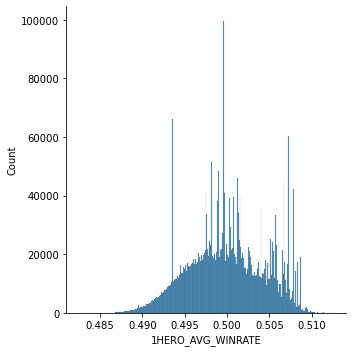

In [23]:
# sns.displot(X['1HERO_AVG_WINRATE'])

In [14]:
# X['1ST_GREATHER_THAN2'] = 0.0
# for idx, row in tqdm.tqdm_notebook(X.iterrows()):
#     if row['1USER_WINRATE'] == -1 or row['2USER_WINRATE'] == -1:
#         X.at[idx, '1ST_GREATHER_THAN2'] = -1
#     elif row['1USER_WINRATE'] > row['2USER_WINRATE']:
#         X.at[idx, '1ST_GREATHER_THAN2'] = 1
#     else:
#         X.at[idx, '1ST_GREATHER_THAN2'] = 0

C:\Users\andry\Anaconda3\envs\subjectify\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


В винрейтах пользователей сильный лик!

In [18]:
sklearn.metrics.log_loss(y, np.array(list(X['1ST_GREATHER_THAN2'])).clip(0.38, 0.62))

0.6723917036743832

In [24]:
import sklearn
import scipy

In [26]:
COUNTERINGS = np.load('./counterings_new.npy')[:, 0]
X['counterings'] = COUNTERINGS.astype(np.float32)

In [27]:
user_outs = np.load('./user_outs.npy', allow_pickle=True)
user_history = {}
for usr, data in tqdm.tqdm_notebook(user_outs):
    user_history[usr] = data

C:\Users\andry\Anaconda3\envs\subjectify\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
ITER = X[['X1', 'X3', 'X2', 'X4']]

In [30]:
X['PERCENTILE_LEFT'] = 0.0
X['PERCENTILE_RIGHT'] = 0.0

for idx, row in tqdm.tqdm_notebook(ITER.iterrows()):
    left = user_history[row['X1']]
    right = user_history[row['X3']]
    X.at[idx, 'PERCENTILE_LEFT'] = scipy.stats.percentileofscore(left, row['X2'])
    X.at[idx, 'PERCENTILE_RIGHT'] = scipy.stats.percentileofscore(right, row['X4'])

X['PERCENTILE_DIFF'] = X['PERCENTILE_LEFT'] - X['PERCENTILE_RIGHT']    

C:\Users\andry\Anaconda3\envs\subjectify\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [31]:
X.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 
        'X1', 'X3', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 
        'X13', 'X14', 'X15', 'X16', 'X17','X18', 'X19', 'X20',], axis=1, inplace=True)

In [32]:
X['MAX_DIV_MIN_LEFT'] = X['MAX_LEFT'] / X['MIN_LEFT']
X['MAX_DIV_MIN_RIGHT'] = X['MAX_RIGHT'] / X['MIN_RIGHT']

X['MAX_DIV_MEAN_LEFT'] = X['MAX_LEFT'] / X['MEAN_LEFT']
X['MAX_DIV_MEAN_RIGHT'] = X['MAX_RIGHT'] / X['MEAN_RIGHT']

X['MIN_DIV_MEAN_LEFT'] = X['MIN_LEFT'] / X['MEAN_LEFT']
X['MIN_DIV_MEAN_RIGHT'] = X['MIN_RIGHT'] / X['MEAN_RIGHT']

X['MAX_MINUS_MIN_LEFT'] = X['MAX_LEFT'] - X['MIN_LEFT']
X['MAX_MINUS_MIN_RIGHT'] = X['MAX_RIGHT'] - X['MIN_RIGHT']

X['MAX_MINUS_MEAN_LEFT'] = X['MAX_LEFT'] - X['MEAN_LEFT']
X['MAX_MINUS_MEAN_RIGHT'] = X['MAX_RIGHT'] - X['MEAN_RIGHT']

X['MEAN_MINUS_MIN_LEFT'] = X['MEAN_LEFT'] - X['MIN_LEFT']
X['MEAN_MINUS_MIN_RIGHT'] = X['MEAN_RIGHT'] - X['MIN_RIGHT']

X['CURR_DIV_MEAN_LEFT'] = X['X2'] / X['MEAN_LEFT']
X['CURR_DIV_MEAN_RIGHT'] = X['X4'] / X['MEAN_RIGHT']

X['MEAN_MINUS_CURR_LEFT'] = X['MEAN_LEFT'] - X['X2']
X['MEAN_MINUS_CURR_RIGHT'] = X['MEAN_RIGHT'] - X['X4']

X['MAX_MINUS_CURR_LEFT'] = (X['MAX_LEFT'] - X['X2']) / X['MEAN_LEFT']
X['MAX_MINUS_CURR_RIGHT'] = (X['MAX_RIGHT'] - X['X4']) / X['MEAN_RIGHT']

X['MIN_MINUS_CURR_LEFT'] = (X['MIN_LEFT'] - X['X2']) / X['MEAN_LEFT']
X['MIN_MINUS_CURR_RIGHT'] = (X['MIN_RIGHT'] - X['X4']) / X['MEAN_RIGHT']

######################################################
X['STD_DIV_MEAN_LEFT'] = X['STD_LEFT'] / X['MEAN_LEFT']
X['STD_DIV_MEAN_RIGHT'] = X['STD_RIGHT'] / X['MEAN_RIGHT']


X['STD_DIV_CURR_LEFT'] = X['STD_LEFT'] / X['X2']
X['STD_DIV_CURR_RIGHT'] = X['STD_RIGHT'] / X['X4']


X['MAX_MINUS_MIN_NORMALIZED_LEFT'] = (X['MAX_LEFT'] - X['MIN_LEFT']) / X['MEAN_LEFT']
X['MAX_MINUS_MIN_NORMALIZED_RIGHT'] = (X['MAX_RIGHT'] - X['MIN_RIGHT']) / X['MEAN_RIGHT']

X['MAX_MINUS_CURR_NN_LEFT'] = X['MAX_LEFT'] - X['X2']
X['MAX_MINUS_CURR_NN_RIGHT'] = X['MAX_RIGHT'] - X['X4']

X['MIN_MINUS_CURR_NN_LEFT'] = X['MIN_LEFT'] - X['X2']
X['MIN_MINUS_CURR_NN_RIGHT'] = X['MIN_RIGHT'] - X['X4']

X['MAX_DIV_CURR_LEFT'] = X['MAX_LEFT'] / X['X2']
X['MAX_DIV_CURR_RIGHT'] = X['MAX_RIGHT'] / X['X4']

X['MIN_DIV_CURR_LEFT'] = X['MIN_LEFT'] / X['X2']
X['MIN_DIV_CURR_RIGHT'] = X['MIN_RIGHT'] / X['X4']

In [33]:
X['MAX_DIV_MIN_DIFF'] = X['MAX_DIV_MIN_LEFT'] - X['MAX_DIV_MIN_RIGHT']
X['MAX_DIV_MEAN_DIFF'] = X['MAX_DIV_MEAN_LEFT'] - X['MAX_DIV_MEAN_RIGHT']
X['MIN_DIV_MEAN_DIFF'] = X['MIN_DIV_MEAN_LEFT'] - X['MIN_DIV_MEAN_RIGHT']
X['MAX_MINUS_MIN_DIFF'] = X['MAX_MINUS_MIN_LEFT'] - X['MAX_MINUS_MIN_RIGHT']
X['MAX_MINUS_MEAN_DIFF'] = X['MAX_MINUS_MEAN_LEFT'] - X['MAX_MINUS_MEAN_RIGHT']
X['MEAN_MINUS_MIN_DIFF'] = X['MEAN_MINUS_MIN_LEFT'] - X['MEAN_MINUS_MIN_RIGHT']
X['CURR_DIV_MEAN_DIFF'] = X['CURR_DIV_MEAN_LEFT'] - X['CURR_DIV_MEAN_RIGHT']
X['MEAN_MINUS_CURR_DIFF'] = X['MEAN_MINUS_CURR_LEFT'] - X['MEAN_MINUS_CURR_RIGHT']
X['MAX_MINUS_CURR_DIFF'] = X['MAX_MINUS_CURR_LEFT'] - X['MAX_MINUS_CURR_RIGHT']
X['MIN_MINUS_CURR_DIFF'] = X['MIN_MINUS_CURR_LEFT'] - X['MIN_MINUS_CURR_RIGHT']

##############################

X['STD_DIV_MEAN_DIFF'] = X['STD_DIV_MEAN_LEFT'] - X['STD_DIV_MEAN_RIGHT']
X['STD_DIV_CURR_DIFF'] = X['STD_DIV_CURR_LEFT'] - X['STD_DIV_CURR_RIGHT']
X['MAX_MINUS_MIN_NORMALIZED_DIFF'] = X['MAX_MINUS_MIN_NORMALIZED_LEFT'] - X['MAX_MINUS_MIN_NORMALIZED_RIGHT']
X['MAX_MINUS_CURR_NN_DIFF'] = X['MAX_MINUS_CURR_NN_LEFT'] - X['MAX_MINUS_CURR_NN_RIGHT']
X['MIN_MINUS_CURR_NN_DIFF'] = X['MIN_MINUS_CURR_NN_LEFT'] - X['MIN_MINUS_CURR_NN_RIGHT']
X['MAX_DIV_CURR_DIFF'] = X['MAX_DIV_CURR_LEFT'] - X['MAX_DIV_CURR_RIGHT']
X['MIN_DIV_CURR_DIFF'] = X['MIN_DIV_CURR_LEFT'] - X['MIN_DIV_CURR_RIGHT']

X['LEFT_CURR_DIV_RIGHT_MEAN'] = X['X2'] / X['MEAN_RIGHT']
X['RIGHT_CURR_DIV_LEFT_MEAN'] = X['X4'] / X['MEAN_LEFT']

X['LEFT_CURR_MINUS_RIGHT_MEAN'] = X['X2'] - X['MEAN_RIGHT']
X['RIGHT_CURR_MINUS_LEFT_MEAN'] = X['X4'] - X['MEAN_LEFT']

X['RIGHT_CURR_MINUS_LEFT_MAX'] = X['X4'] - X['MAX_LEFT']
X['LEFT_CURR_MINUS_RIGHT_MAX'] = X['X2'] - X['MAX_RIGHT']

X['RIGHT_CURR_MINUS_LEFT_MIN'] = X['X4'] - X['MIN_LEFT']
X['LEFT_CURR_MINUS_RIGHT_MIN'] = X['X2'] - X['MIN_RIGHT']

X['LEFT_STD_DIV_RIGHT_CURR'] = X['STD_LEFT'] / X['X4']
X['RIGHT_STD_DIV_RIGHT_CURR'] = X['STD_RIGHT'] / X['X2']

X['LEFT_STD_DIV_RIGHT_MEAN'] = X['STD_LEFT'] / X['MEAN_RIGHT']
X['RIGHT_STD_DIV_LEFT_MEAN'] = X['STD_RIGHT'] / X['MEAN_LEFT']

X['LEFT_CURR_DIV_RIGHT_MEAN_DIFF'] = X['LEFT_CURR_DIV_RIGHT_MEAN'] - X['RIGHT_CURR_DIV_LEFT_MEAN']
X['LEFT_CURR_MINUS_RIGHT_MEAN_DIFF'] = X['LEFT_CURR_MINUS_RIGHT_MEAN'] - X['RIGHT_CURR_MINUS_LEFT_MEAN']
X['RIGHT_CURR_MINUS_LEFT_MAX_DIFF'] = X['RIGHT_CURR_MINUS_LEFT_MAX'] - X['LEFT_CURR_MINUS_RIGHT_MAX']
X['RIGHT_CURR_MINUS_LEFT_MIN_DIFF'] = X['RIGHT_CURR_MINUS_LEFT_MIN'] - X['LEFT_CURR_MINUS_RIGHT_MIN']
X['LEFT_STD_DIV_RIGHT_CURR_DIFF'] = X['LEFT_STD_DIV_RIGHT_CURR'] - X['RIGHT_STD_DIV_RIGHT_CURR']
X['LEFT_STD_DIV_RIGHT_MEAN'] = X['LEFT_STD_DIV_RIGHT_MEAN'] - X['RIGHT_STD_DIV_LEFT_MEAN']

##############################
X['MEAN_DIFF'] = X['MEAN_LEFT'] - X['MEAN_RIGHT']
X['MAX_MIN_DIFF'] = X['MAX_MIN_LEFT'] - X['MAX_MIN_RIGHT']
X['MAX_DIFF'] = X['MAX_LEFT'] - X['MAX_RIGHT']
X['MIN_DIFF'] = X['MIN_LEFT'] - X['MIN_RIGHT']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

In [35]:
import sklearn

In [36]:
from catboost import *

In [52]:
model_params = {
    'learning_rate': 0.025,
    'max_depth': 10,
    'iterations': 20000,
    'loss_function': 'Logloss',
    'verbose': True,
    'random_seed': 1337,
    'task_type': 'GPU',
    'one_hot_max_size': 10,
}

In [53]:
model = CatBoost(model_params)

In [39]:
dataset_train = Pool(X_train, y_train, cat_features=['X0'])

In [40]:
dataset_val = Pool(X_test, y_test, cat_features=['X0'])

In [ ]:
model.fit(dataset_train, eval_set=dataset_val)

In [55]:
model.save_model('model_last')

In [33]:
# 0.6056997 - with diffs
# 19999:	learn: 0.5078032	test: 0.6057102	best: 0.6056997 (19826)	total: 20m 16s	remaining: 0us

# Новые фичи на рейтинге:
#learn: 0.4992369	test: 0.5985539	best: 0.5985455 (19939)	total: 22m 31s	remaining: 0us

#19999:	learn: 0.4916491	test: 0.5881486	best: 0.5881246 (18822)	total: 27m 6s	remaining: 0us

#19999:	learn: 0.3095805	test: 0.4020079	best: 0.4020038 (19927)	total: 1h 2m 28s	remaining: 0us

In [ ]:
sorted(list(zip(model.feature_importances_, X_test.columns)), key=lambda x: -x[0])

In [83]:
top_100 = sorted(list(zip(model.feature_importances_, X_test.columns)), key=lambda x: -x[0])[:100]

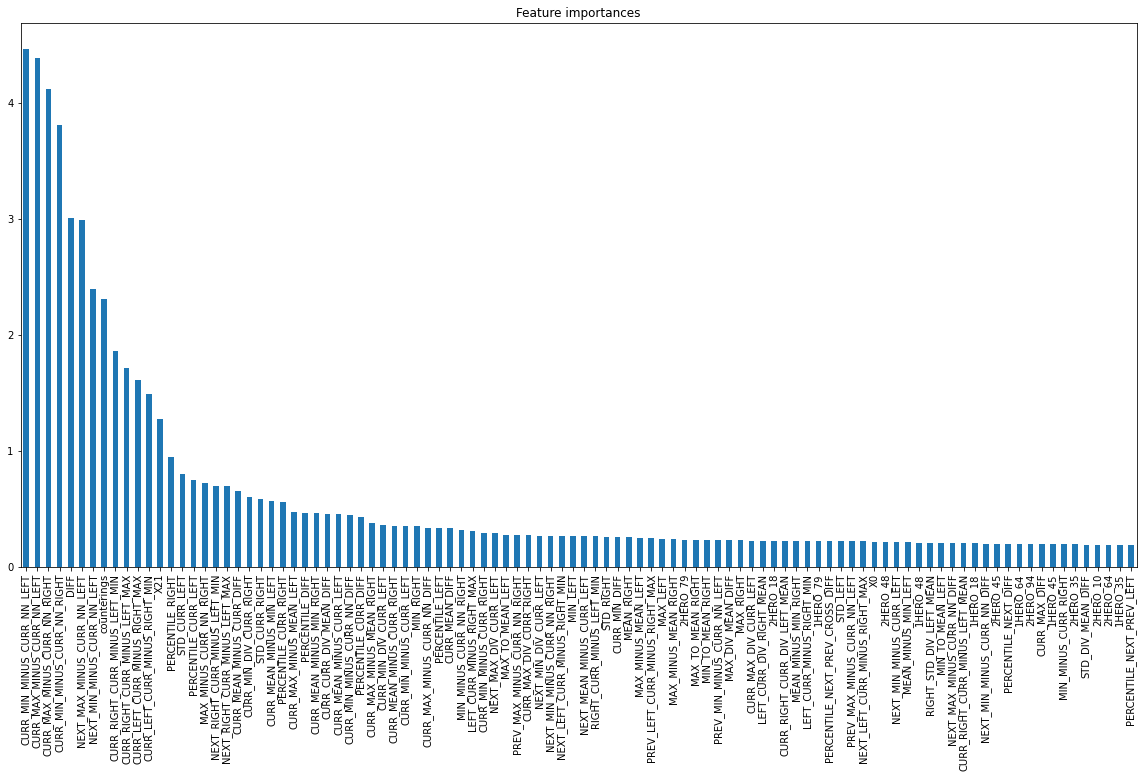

In [87]:
import matplotlib.pyplot as plt

forest_importances = pd.Series([x[0] for x in top_100], index=[x[1] for x in top_100])

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax, figsize=(20,10))
ax.set_title("Feature importances")
plt.savefig('100.png', dpi=300, bbox_inches="tight")

### Найдем винрейты

In [113]:
# a = set(train_data['X1'])
# b = set(train_data['X3'])
# c = a.union(b)

In [ ]:
# rates = {}
# heroes_stats_total = {}

# for user_id in tqdm.tqdm_notebook(c):
#     first = train_data[train_data['X1'] == user_id]
#     second = train_data[train_data['X3'] == user_id]
    
#     targets_left = first['target']
#     targets_right = second['target']
#     rates[user_id] = [sum(targets_left) + len(targets_right) - sum(targets_right), (len(targets_left) + len(targets_right))]
    

#     pers_left = set()
#     for x in ['X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12']:
#         pers_left = pers_left.union(set(first[x]))

#     second = train_data[train_data['X3'] == user_id]
#     pers_right = set()    
#     for x in ['X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20']:
#         pers_right = pers_right.union(set(first[x]))

#     heroes_for_user = {}    
#     for hero in pers_left:
#         plays_with_hero_left = first[(first['X5'] == hero) | 
#                                 (first['X6'] == hero) | 
#                                 (first['X7'] == hero) | 
#                                 (first['X8'] == hero) | 
#                                 (first['X9'] == hero) | 
#                                 (first['X10'] == hero) | 
#                                 (first['X11'] == hero) | 
#                                 (first['X12'] == hero)]['target']
#         heroes_for_user[hero] = list(plays_with_hero_left)

#     for hero in pers_right:
#         plays_with_hero_right = first[(first['X13'] == hero) | 
#                                 (first['X14'] == hero) | 
#                                 (first['X15'] == hero) | 
#                                 (first['X16'] == hero) | 
#                                 (first['X17'] == hero) | 
#                                 (first['X18'] == hero) | 
#                                 (first['X19'] == hero) | 
#                                 (first['X20'] == hero)]['target']
#         if hero in heroes_for_user:
#             heroes_for_user[hero].extend([1 - x for x in list(plays_with_hero_right)])
#         else:
#             heroes_for_user[hero] = [1 - x for x in list(plays_with_hero_right)]

#     heroes_stats_total[user_id] = {}
#     for hero in heroes_for_user.keys():
#         heroes_stats_total[user_id][hero] = [sum(heroes_for_user[hero]), len(heroes_for_user[hero])]

### Винрейты героев

In [4]:
# hero_rates = {}

# for hero_id in tqdm.tqdm_notebook(range(101)):
#     targets_left = train_data[(train_data['X5'] != hero_id) & 
#                              (train_data['X6'] != hero_id) & 
#                              (train_data['X7'] != hero_id) & 
#                              (train_data['X8'] != hero_id) & 
#                              (train_data['X9'] != hero_id) & 
#                              (train_data['X10'] != hero_id) & 
#                              (train_data['X11'] != hero_id) & 
#                              (train_data['X12'] != hero_id)]['target']
    
#     targets_right = train_data[(train_data['X13'] != hero_id) & 
#                              (train_data['X14'] != hero_id) & 
#                              (train_data['X15'] != hero_id) & 
#                              (train_data['X16'] != hero_id) & 
#                              (train_data['X17'] != hero_id) & 
#                              (train_data['X18'] != hero_id) & 
#                              (train_data['X19'] != hero_id) & 
#                              (train_data['X20'] != hero_id)]['target']
    
#     hero_rates[hero_id] = [sum(targets_left) + (len(targets_right) - sum(targets_right)), len(targets_left) + len(targets_right)]

C:\Users\andry\Anaconda3\envs\subjectify\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
# hero_winrates = {k: x[0]/x[1] for k, x in hero_rates.items()}

In [7]:
# np.save('hero_winrates.npy', hero_winrates)

C:\Users\andry\Anaconda3\envs\subjectify\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

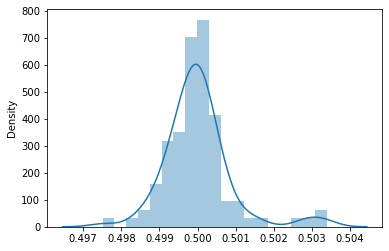

In [62]:
# sns.distplot(list(hero_winrates.values()))

### User winrates

Сначала это были винрейты, но пришлось переделать в плейрейты (как часто игрок играет с данным героем) т.к. была сильная утечка таргета

In [8]:
# X['1USER_WINRATE'] = 0.0
# X['2USER_WINRATE'] = 0.0

# X['1_USER_HERO_1_WINRATE'] = 0.0
# X['1_USER_HERO_2_WINRATE'] = 0.0
# X['1_USER_HERO_3_WINRATE'] = 0.0
# X['1_USER_HERO_4_WINRATE'] = 0.0
# X['1_USER_HERO_5_WINRATE'] = 0.0
# X['1_USER_HERO_6_WINRATE'] = 0.0
# X['1_USER_HERO_7_WINRATE'] = 0.0
# X['1_USER_HERO_8_WINRATE'] = 0.0

# X['2_USER_HERO_1_WINRATE'] = 0.0
# X['2_USER_HERO_2_WINRATE'] = 0.0
# X['2_USER_HERO_3_WINRATE'] = 0.0
# X['2_USER_HERO_4_WINRATE'] = 0.0
# X['2_USER_HERO_5_WINRATE'] = 0.0
# X['2_USER_HERO_6_WINRATE'] = 0.0
# X['2_USER_HERO_7_WINRATE'] = 0.0
# X['2_USER_HERO_8_WINRATE'] = 0.0

In [9]:
# for idx, row in tqdm.tqdm_notebook(X.iterrows()):
#     first_rate = rates[row['X1']]
#     second_rate = rates[row['X3']]
    
#     first_hero_rate = heroes_stats_total[row['X1']]
#     second_hero_rate = heroes_stats_total[row['X3']]
    
    
#     if first_rate[1] >= 10:
#         X.at[idx, '1USER_WINRATE'] = first_rate[0] / first_rate[1]
#     else:
#         X.at[idx, '1USER_WINRATE'] = -1
    
#     if second_rate[1] >= 10:
#         X.at[idx, '2USER_WINRATE'] = second_rate[0] / second_rate[1]
#     else:
#         X.at[idx, '2USER_WINRATE'] = -1
        
        
#     if first_rate[1] >= 5:
#         X.at[idx, '1_USER_HERO_1_WINRATE'] = first_hero_rate[row['X5']][1] / first_rate[1]
#     else:
#         X.at[idx, '1_USER_HERO_1_WINRATE'] = -1
    
#     if first_rate[1] >= 5:
#         X.at[idx, '1_USER_HERO_2_WINRATE'] = first_hero_rate[row['X6']][1] / first_rate[1]
#     else:
#         X.at[idx, '1_USER_HERO_2_WINRATE'] = -1
        
#     if first_rate[1] >= 5:
#         X.at[idx, '1_USER_HERO_3_WINRATE'] = first_hero_rate[row['X7']][1] / first_rate[1]
#     else:
#         X.at[idx, '1_USER_HERO_3_WINRATE'] = -1
        
#     if first_rate[1] >= 5:
#         X.at[idx, '1_USER_HERO_4_WINRATE'] = first_hero_rate[row['X8']][1] / first_rate[1]
#     else:
#         X.at[idx, '1_USER_HERO_4_WINRATE'] = -1
        
#     if first_rate[1] >= 5:
#         X.at[idx, '1_USER_HERO_5_WINRATE'] = first_hero_rate[row['X9']][1] / first_rate[1]
#     else:
#         X.at[idx, '1_USER_HERO_5_WINRATE'] = -1
    
#     if first_rate[1] >= 5:
#         X.at[idx, '1_USER_HERO_6_WINRATE'] = first_hero_rate[row['X10']][1] / first_rate[1]
#     else:
#         X.at[idx, '1_USER_HERO_6_WINRATE'] = -1
        
#     if first_rate[1] >= 5:
#         X.at[idx, '1_USER_HERO_7_WINRATE'] = first_hero_rate[row['X11']][1] / first_rate[1]
#     else:
#         X.at[idx, '1_USER_HERO_7_WINRATE'] = -1
        
#     if first_rate[1] >= 5:
#         X.at[idx, '1_USER_HERO_8_WINRATE'] = first_hero_rate[row['X12']][1] / first_rate[1]
#     else:
#         X.at[idx, '1_USER_HERO_8_WINRATE'] = -1
        
        
        
#     if second_rate[1] >= 5:
#         X.at[idx, '2_USER_HERO_1_WINRATE'] = second_hero_rate[row['X13']][1] / second_rate[1]
#     else:
#         X.at[idx, '2_USER_HERO_1_WINRATE'] = -1
    
#     if second_rate[1] >= 5:
#         X.at[idx, '2_USER_HERO_2_WINRATE'] = second_hero_rate[row['X14']][1] / second_rate[1]
#     else:
#         X.at[idx, '2_USER_HERO_2_WINRATE'] = -1
        
#     if second_rate[1] >= 5:
#         X.at[idx, '2_USER_HERO_3_WINRATE'] = second_hero_rate[row['X15']][1] / second_rate[1]
#     else:
#         X.at[idx, '2_USER_HERO_3_WINRATE'] = -1
        
#     if second_rate[1] >= 5:
#         X.at[idx, '2_USER_HERO_4_WINRATE'] = second_hero_rate[row['X16']][1] / second_rate[1]
#     else:
#         X.at[idx, '2_USER_HERO_4_WINRATE'] = -1
        
#     if second_rate[1] >= 5:
#         X.at[idx, '2_USER_HERO_5_WINRATE'] = second_hero_rate[row['X17']][1] / second_rate[1]
#     else:
#         X.at[idx, '2_USER_HERO_5_WINRATE'] = -1
    
#     if second_rate[1] >= 5:
#         X.at[idx, '2_USER_HERO_6_WINRATE'] = second_hero_rate[row['X18']][1] / second_rate[1]
#     else:
#         X.at[idx, '2_USER_HERO_6_WINRATE'] = -1
        
#     if second_rate[1] >= 5:
#         X.at[idx, '2_USER_HERO_7_WINRATE'] = second_hero_rate[row['X19']][1] / second_rate[1]
#     else:
#         X.at[idx, '2_USER_HERO_7_WINRATE'] = -1
        
#     if second_rate[1] >= 5:
#         X.at[idx, '2_USER_HERO_8_WINRATE'] = second_hero_rate[row['X20']][1] / second_rate[1]
#     else:
#         X.at[idx, '2_USER_HERO_8_WINRATE'] = -1

C:\Users\andry\Anaconda3\envs\subjectify\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


### User avg rating

In [6]:
from joblib import Parallel, delayed

In [7]:
a = set(data['X1'])
b = set(data['X3'])
c = a.union(b)

In [8]:
def count(user_id):
    first = data[data['X1'] == user_id]
    second = data[data['X3'] == user_id]
    
    rates_left = list(first['X2'])
    rates_right = list(second['X4'])
    return [user_id, rates_left + rates_right]    

In [9]:
outs = Parallel(n_jobs=8)(delayed(count)(user_id) for user_id in tqdm.tqdm_notebook(c))

C:\Users\andry\Anaconda3\envs\subjectify\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [10]:
# Percentile counters
np.save('user_outs.npy', outs)

C:\Users\andry\Anaconda3\envs\subjectify\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [10]:
user_rating_stats = {}

In [11]:
for usr, data in tqdm.tqdm_notebook(outs):
    user_rating_stats[usr] = [np.mean(data), np.max(data), np.min(data), np.std(data)]

C:\Users\andry\Anaconda3\envs\subjectify\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [12]:
np.save('user_rating_stats_full.npy', user_rating_stats)

In [46]:
user_rating_stats = {}

for user_id in tqdm.tqdm_notebook(c):
    first = train_data[train_data['X1'] == user_id]
    second = train_data[train_data['X3'] == user_id]
    
    rates_left = list(first['X2'])
    rates_right = list(second['X4'])
    user_rating_stats[user_id] = rates_left + rates_right

C:\Users\andry\Anaconda3\envs\subjectify\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


## Synergy

In [ ]:
hero_countering = np.zeros((101, 101))
for hero_id_first in tqdm.tqdm_notebook(range(101)):
    for hero_id_second in tqdm.tqdm_notebook(range(101)):
        targets_left = train_data[((train_data['X5'] == hero_id_first) | 
                             (train_data['X6'] == hero_id_first) | 
                             (train_data['X7'] == hero_id_first) | 
                             (train_data['X8'] == hero_id_first) | 
                             (train_data['X9'] == hero_id_first) | 
                             (train_data['X10'] == hero_id_first) | 
                             (train_data['X11'] == hero_id_first) | 
                             (train_data['X12'] == hero_id_first)) & 
                                   
                            ((train_data['X13'] == hero_id_second) | 
                             (train_data['X14'] == hero_id_second) | 
                             (train_data['X15'] == hero_id_second) | 
                             (train_data['X16'] == hero_id_second) | 
                             (train_data['X17'] == hero_id_second) | 
                             (train_data['X18'] == hero_id_second) | 
                             (train_data['X19'] == hero_id_second) | 
                             (train_data['X20'] == hero_id_second)
                            )]['target']
    
    
        targets_right = train_data[((train_data['X13'] == hero_id_first) | 
                                 (train_data['X14'] == hero_id_first) | 
                                 (train_data['X15'] == hero_id_first) | 
                                 (train_data['X16'] == hero_id_first) | 
                                 (train_data['X17'] == hero_id_first) | 
                                 (train_data['X18'] == hero_id_first) | 
                                 (train_data['X19'] == hero_id_first) | 
                                 (train_data['X20'] == hero_id_first)) & (
                                ((train_data['X5'] == hero_id_second) | 
                                 (train_data['X6'] == hero_id_second) | 
                                 (train_data['X7'] == hero_id_second) | 
                                 (train_data['X8'] == hero_id_second) | 
                                 (train_data['X9'] == hero_id_second) | 
                                 (train_data['X10'] == hero_id_second) | 
                                 (train_data['X11'] == hero_id_second) | 
                                 (train_data['X12'] == hero_id_second))
                                )]['target']
        
        hero_countering[hero_id_first][hero_id_second] = (sum(targets_left) + len(targets_right) - sum(targets_right)) / (len(targets_left) + len(targets_right))

In [16]:
#np.save("hero_countering.npy", hero_countering)

In [49]:
hero_countering = np.load('./hero_countering.npy')

In [52]:
counterings = []
for idx, row in tqdm.tqdm_notebook(test_data.iterrows()):
    sums = 0
    sums2 = 0
    for first in ['X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12']:
        for second in ['X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20']:
            sums += hero_countering[row[first]][row[second]]
            sums2 += hero_countering[row[second]][row[first]]
    counterings.append([sums, sums2])

C:\Users\andry\Anaconda3\envs\subjectify\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [53]:
np.save('counterings_test.npy', counterings)

In [51]:
from joblib import Parallel, delayed

In [22]:
counterings = []
for idx, row in tqdm.tqdm_notebook(train_data.iterrows()):
    sums = 0
    sums2 = 0
    for first in ['X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12']:
        for second in ['X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20']:
            sums += hero_countering[row[first]][row[second]]
            sums2 += hero_countering[row[second]][row[first]]
    counterings.append([sums, sums2])

C:\Users\andry\Anaconda3\envs\subjectify\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [30]:
np.save('counterings_new.npy', counterings)

In [25]:
import scipy

In [23]:
COUNTERINGS = np.array(counterings)[:, 0]

In [29]:
scipy.stats.pearsonr(np.array(counterings)[:, 0], y)

(0.13784137992460352, 0.0)

### Hero winrates

In [ ]:
# hero_rates = {}

# for hero_id_1 in tqdm.tqdm_notebook(range(101)):
#     for hero_id_2 in tqdm.tqdm_notebook(range(hero_id_1, 101)):
#         targets_left = train_data[((train_data['X5'] == hero_id_1) | 
#                                  (train_data['X6'] == hero_id_1) | 
#                                  (train_data['X7'] == hero_id_1) | 
#                                  (train_data['X8'] == hero_id_1) | 
#                                  (train_data['X9'] == hero_id_1) | 
#                                  (train_data['X10'] == hero_id_1) | 
#                                  (train_data['X11'] == hero_id_1) | 
#                                  (train_data['X12'] == hero_id_1)) & (
            
#                                 ((train_data['X5'] == hero_id_2) | 
#                                  (train_data['X6'] == hero_id_2) | 
#                                  (train_data['X7'] == hero_id_2) | 
#                                  (train_data['X8'] == hero_id_2) | 
#                                  (train_data['X9'] == hero_id_2) | 
#                                  (train_data['X10'] == hero_id_2) | 
#                                  (train_data['X11'] == hero_id_2) | 
#                                  (train_data['X12'] == hero_id_2)))]['target']

#         targets_right =  train_data[((train_data['X13'] == hero_id_1) | 
#                                  (train_data['X14'] == hero_id_1) | 
#                                  (train_data['X15'] == hero_id_1) | 
#                                  (train_data['X16'] == hero_id_1) | 
#                                  (train_data['X17'] == hero_id_1) | 
#                                  (train_data['X18'] == hero_id_1) | 
#                                  (train_data['X19'] == hero_id_1) | 
#                                  (train_data['X20'] == hero_id_1)) & (
            
#                                 ((train_data['X13'] == hero_id_2) | 
#                                  (train_data['X14'] == hero_id_2) | 
#                                  (train_data['X15'] == hero_id_2) | 
#                                  (train_data['X16'] == hero_id_2) | 
#                                  (train_data['X17'] == hero_id_2) | 
#                                  (train_data['X18'] == hero_id_2) | 
#                                  (train_data['X19'] == hero_id_2) | 
#                                  (train_data['X20'] == hero_id_2)))]['target']

#         hero_rates[str(hero_id_1) + '_' + str(hero_id_2)] = [sum(targets_left) + 0.6129 * (len(targets_right) - sum(targets_right)), len(targets_left) + len(targets_right)]
#         a = hero_rates[str(hero_id_1) + '_' + str(hero_id_2)]
#         print(a[0] / a[1])

### User ratings day by day

In [191]:
a = set(data['X1'])
b = set(data['X3'])
c = a.union(b)

In [192]:
def preproc(user_id):
    ratings = []
    targets = []
    times = []
    modes = []
    history = {}
    cur_data = data[((data['X1'] == user_id) | (data['X3'] == user_id))]
    for idx, row in cur_data.iterrows():
        if row['X1'] == user_id:
            if row['X21'] in history:
                history[row['X21']].append(row['X2'])
            else:
                history[row['X21']] = [row['X2']]
        else:
            if row['X21'] in history:
                history[row['X21']].append(row['X4'])
            else:
                history[row['X21']] = [row['X4']]

    lst = sorted(list(zip(times, ratings, targets, modes)), key=lambda x: x[0])
    history = {int(k):v for k,v in history.items()}
    dct = collections.OrderedDict(sorted(history.items()))
    return [user_id, dct]

In [ ]:
from joblib import Parallel, delayed
day_by_day_ratings = Parallel(n_jobs=4)(delayed(preproc)(user_id) for user_id in tqdm.tqdm_notebook(c))

C:\Users\andry\Anaconda3\envs\subjectify\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [146]:
np.save('day_by_day_ratings.npy', day_by_day_ratings)